In [1]:
import sys
sys.path.append("../src")
from data.fetch_prices import get_energy_prices
from models.lssl import LSSLConfig, LSSLModelForPriceForecast
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

torch.cuda.empty_cache()

In [2]:
start_date = "202405300000"
end_date = "202406300000"
df_prices = get_energy_prices(start_date, end_date)

In [3]:
class PriceWindowDataset(Dataset):
    """
    Slice a univariate price series into
      • input windows of length `seq_len`
      • target windows of length `horizon`
    stride = 1  → fully-overlapping windows
    """

    def __init__(self, df, seq_len: int, horizon: int = 1, stride: int = 1):
        prices = (
            df.sort_values("datetime")["price_EUR_MWh"]
              .to_numpy(dtype=np.float32)
        )
        
        # Normalize the prices to prevent gradient explosion
        self.price_mean = prices.mean()
        self.price_std = prices.std()
        prices = (prices - self.price_mean) / self.price_std
        
        self.seq_len = seq_len
        self.horizon = horizon
        self.stride = stride
        self.prices = prices
        self.n_total = len(prices)

        min_needed = seq_len + horizon
        if self.n_total < min_needed:
            raise ValueError(
                f"Need at least seq_len + horizon = {min_needed} rows, "
                f"but only have {self.n_total}."
            )

        # start indices for each window
        self.starts = np.arange(0, self.n_total - min_needed + 1, stride, dtype=np.int64)

    def __len__(self):
        return len(self.starts)

    def __getitem__(self, idx):
        s = self.starts[idx]
        e_in  = s + self.seq_len
        e_out = e_in + self.horizon

        # .copy() avoids the "non-writable" NumPy → Torch warning
        x = torch.from_numpy(self.prices[s:e_in].copy()).unsqueeze(-1)   # [seq_len, 1]
        y = torch.from_numpy(self.prices[e_in:e_out].copy())             # [horizon]
        return x, y
    
    def denormalize(self, normalized_prices):
        """Convert normalized prices back to original scale"""
        return normalized_prices * self.price_std + self.price_mean

In [4]:
config = LSSLConfig(
    state_size   = 64,
    hidden_size  = 128,
    num_channels = 1,
    num_layers   = 1,
    dropout      = 0.1,
    train_A      = True,
    train_dt     = True,
)

seq_len  = 168       
horizon  = 168        # predict next 24 h
batch_sz = 32        # increased batch size for faster training

dataset = PriceWindowDataset(df_prices, seq_len, horizon)
loader  = torch.utils.data.DataLoader(dataset, batch_size=batch_sz, shuffle=True)


model   = LSSLModelForPriceForecast(config, horizon).cuda()
# dataset = PriceWindowDataset(df_prices, seq_len, horizon)
# loader  = DataLoader(dataset, batch_size=batch_size, shuffle=True)

criterion = torch.nn.MSELoss().to("cuda")
optim     = torch.optim.AdamW(model.parameters(), lr=1e-4)  # Much lower learning rate

In [5]:
for epoch in range(30):
    model.train()
    epoch_loss = 0.0
    num_batches = 0
    
    for x, y in loader:
        x, y = x.cuda(), y.cuda()
        optim.zero_grad()
        y_hat = model(x, mode="convolutional")     # [B, horizon] - much faster!
        loss  = criterion(y_hat, y)
        loss.backward()
        
        # Add gradient clipping to prevent explosion
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optim.step()
        
        epoch_loss += loss.item()
        num_batches += 1

    avg_loss = epoch_loss / num_batches
    print(f"Epoch {epoch + 1}/30 - Loss: {avg_loss:.4f}")
    
    # Stop early if loss becomes NaN
    if np.isnan(avg_loss):
        print("Training stopped due to NaN loss")
        break


Epoch 1/30 - Loss: 25.3592
Epoch 2/30 - Loss: 17.9084
Epoch 3/30 - Loss: 13.3239
Epoch 4/30 - Loss: 10.3831
Epoch 5/30 - Loss: 8.3454
Epoch 6/30 - Loss: 7.0238
Epoch 7/30 - Loss: 6.2174
Epoch 8/30 - Loss: 5.7122
Epoch 9/30 - Loss: 5.0945
Epoch 10/30 - Loss: 4.7328
Epoch 11/30 - Loss: 4.4992
Epoch 12/30 - Loss: 4.2358
Epoch 13/30 - Loss: 4.0092
Epoch 14/30 - Loss: 3.8395
Epoch 15/30 - Loss: 3.5938
Epoch 16/30 - Loss: 3.4927
Epoch 17/30 - Loss: 3.3552
Epoch 18/30 - Loss: 3.2494
Epoch 19/30 - Loss: 3.0506
Epoch 20/30 - Loss: 2.9054
Epoch 21/30 - Loss: 2.7821
Epoch 22/30 - Loss: 2.6884
Epoch 23/30 - Loss: 2.5518
Epoch 24/30 - Loss: 2.4499
Epoch 25/30 - Loss: 2.3296
Epoch 26/30 - Loss: 2.2751
Epoch 27/30 - Loss: 2.1658
Epoch 28/30 - Loss: 2.1021
Epoch 29/30 - Loss: 1.9557
Epoch 30/30 - Loss: 1.8859


In [6]:
last_window_np = df_prices.sort_values("datetime")["price_EUR_MWh"].to_numpy(dtype=np.float32)[-seq_len:]

# Normalize the last window using the same stats as training data
last_window_normalized = (last_window_np - dataset.price_mean) / dataset.price_std

last_window = (
    torch.from_numpy(last_window_normalized)
         .unsqueeze(0)      # batch dim
         .unsqueeze(-1)     # feature dim
         .to("cuda")
)                           # shape [1, seq_len, 1]

model.eval()
with torch.no_grad():
    forecast_normalized = model(last_window, mode="recurrent").cpu().squeeze(0).numpy()
    # Denormalize the forecast back to original scale
    forecast = dataset.denormalize(forecast_normalized)

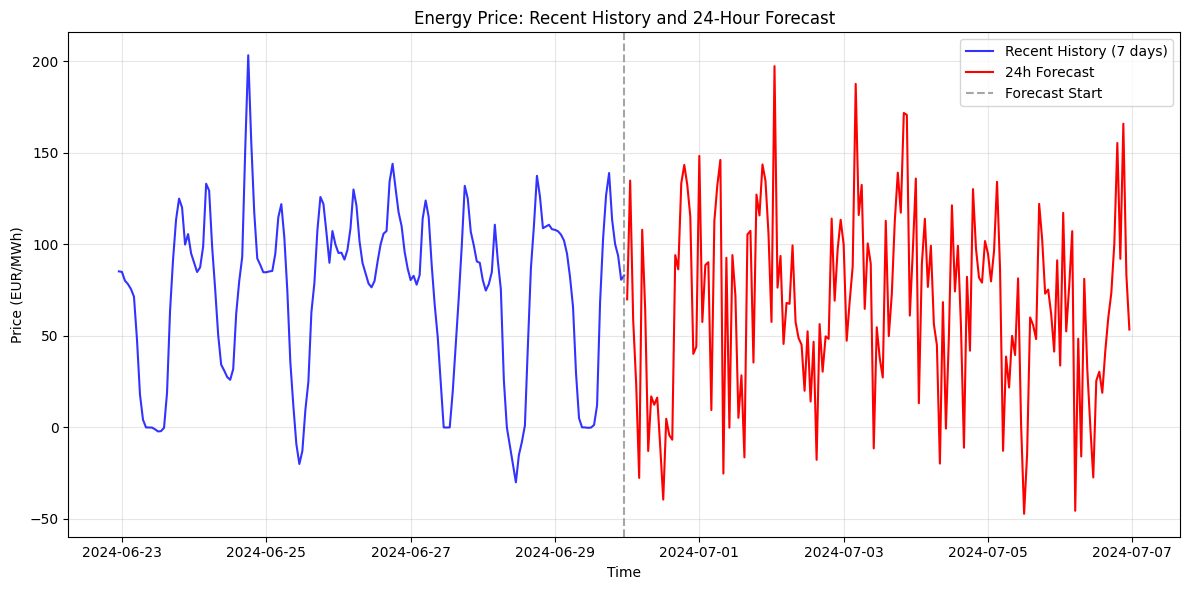

In [9]:
# Prepare data for plotting
recent_days = 7 * 24  # 7 days worth of hourly data
recent_data = df_prices.sort_values("datetime").tail(recent_days)

last_time   = df_prices["datetime"].max()              # last timestamp in your data
future_times = pd.date_range(
    last_time + pd.Timedelta(hours=1),
    periods = 168,
    freq    = "h"
)

plt.figure(figsize=(12, 6))

plt.plot(recent_data["datetime"], recent_data["price_EUR_MWh"], 
         label="Recent History (7 days)", linewidth=1.5, color='blue', alpha=0.8)
plt.plot(future_times, forecast, 
         label="24h Forecast", linewidth=1.5, color='red')

# Add a vertical line to separate history from forecast
plt.axvline(x=last_time, color='gray', linestyle='--', alpha=0.7, label='Forecast Start')

plt.xlabel("Time")
plt.ylabel("Price (EUR/MWh)")
plt.title("Energy Price: Recent History and 24-Hour Forecast")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
